In [29]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random

In [31]:
np.random.seed(0)

In [32]:
with open('german-traffic-signs/train.p','rb') as f:
  train_data = pickle.load(f)
with open('german-traffic-signs/valid.p','rb') as f:
  val_data = pickle.load(f)
with open('german-traffic-signs/test.p','rb') as f:
  test_data = pickle.load(f)
X_train,y_train = train_data['features'],train_data['labels'] 
X_val,y_val = val_data['features'],val_data['labels']     
X_test,y_test = test_data['features'],test_data['labels']          

In [33]:
assert(X_train.shape[0] == y_train.shape[0]),"The number of images is not equal in x and y"
assert(X_test.shape[0] == y_test.shape[0]),"The number of images is not equal in x and y"
assert(X_val.shape[0] == y_val.shape[0]),"The number of images is not equal in x and y"

In [34]:
data=pd.read_csv('german-traffic-signs/signnames.csv')

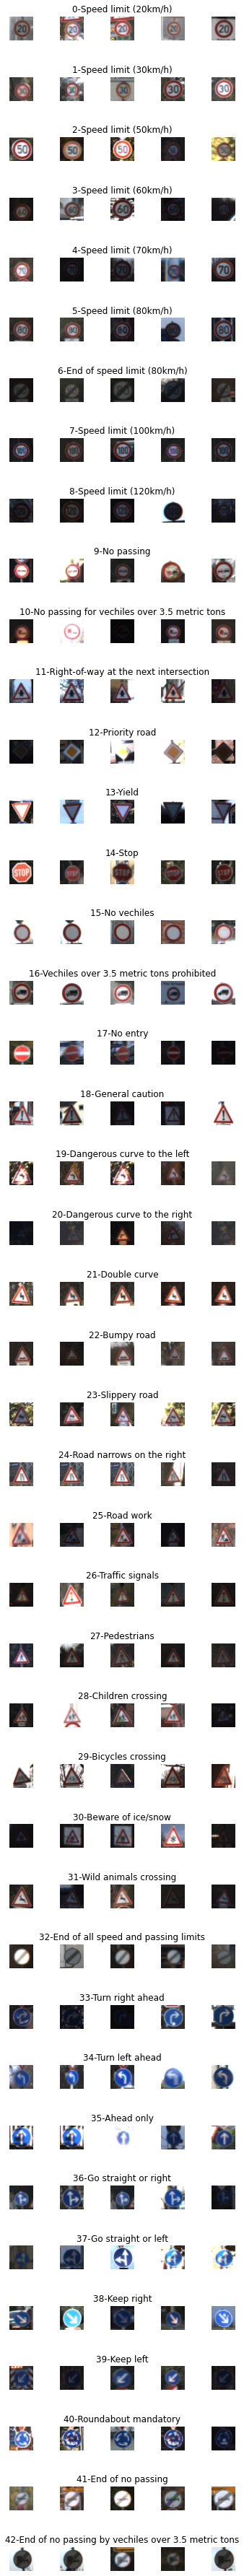

In [35]:
num_of_samples = []

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 50))
fig.tight_layout()
for i in range(cols):
    for j,row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, (len(x_selected)-1)), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j)+"-"+row["SignName"])
            num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of images')

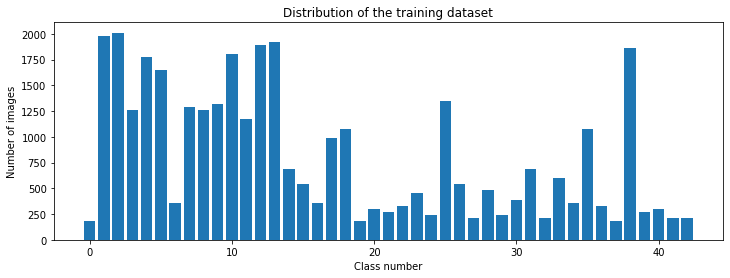

In [36]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")

(32, 32, 3)


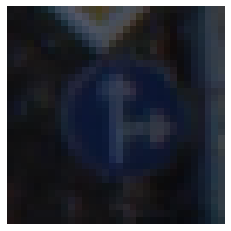

In [37]:
import cv2

plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)

In [38]:
def grayscale(img):
  return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

(-0.5, 31.5, 31.5, -0.5)

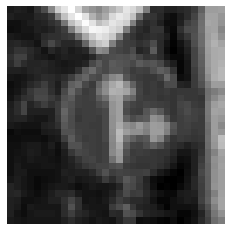

In [39]:
img=grayscale(X_train[1000])
plt.imshow(img,cmap='gray')
plt.axis("off")

In [40]:
def equalize(img):
  img=cv2.equalizeHist(img)
  return img

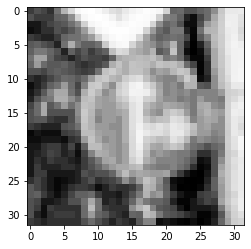

In [41]:
img=equalize(img)
plt.imshow(img,cmap="gray")

In [42]:
def preproccessing(img):
  img=grayscale(img)
  img=equalize(img)
  img=img/255
  return img

In [43]:
X_train = np.array(list(map(preproccessing,X_train)))
X_val = np.array(list(map(preproccessing,X_val)))
X_test = np.array(list(map(preproccessing,X_test)))

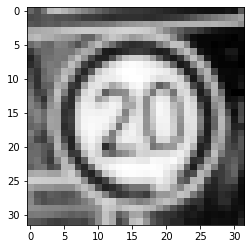

In [44]:
plt.imshow(X_train[random.randint(0,len(X_train) - 1)],cmap="gray")

In [45]:
X_train = X_train.reshape(34799,32,32,1)
X_test = X_test.reshape(12630,32,32,1)
X_val=X_val.reshape(4410,32,32,1)

In [46]:
from keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(width_shift_range=0.1,
                   height_shift_range=0.1,
                   zoom_range=0.2,
                   shear_range=0.1,
                   rotation_range=10)

data_generator.fit(X_train)

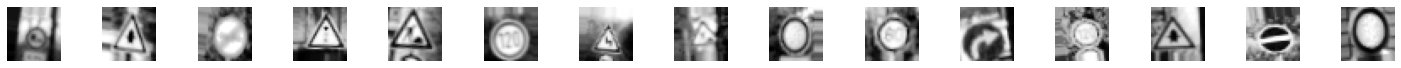

In [47]:
batches = data_generator.flow(X_train, y_train,batch_size=20)
X_batch, y_batch = next(batches)
fig, axs = plt.subplots(1,15, figsize=(20,5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32,32),cmap='gray')
  axs[i].axis('off')

In [48]:
y_train = to_categorical(y_train,43)
y_test = to_categorical(y_test,43)
y_val = to_categorical(y_val,43)

In [49]:
def IeNet_model():
  model = Sequential()
  model.add(Conv2D(60,(5,5),input_shape=(32,32,1),activation='relu'))
  model.add(Conv2D(60,(5,5),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(30,(3,3),activation='relu'))
  model.add(Conv2D(30,(3,3),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.5))
  
  model.add(Flatten())
  model.add(Dense(500,activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes,activation='softmax'))
  model.compile(Adam(0.001),loss = 'categorical_crossentropy',metrics = ['accuracy'])
  return model

In [50]:
model=IeNet_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 4, 30)         

In [51]:
h=model.fit_generator(data_generator.flow(X_train, y_train, batch_size=50),
                            steps_per_epoch=600,
                            epochs=20,
                            validation_data=(X_val, y_val), shuffle = 1)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


600/600 [==============================] - 13s 21ms/step - loss: 2.9851 - accuracy: 0.1905 - val_loss: 0.5773 - val_accuracy: 0.8410
Epoch 2/20
600/600 [==============================] - 26s 44ms/step - loss: 1.1594 - accuracy: 0.6440 - val_loss: 0.2699 - val_accuracy: 0.9048
Epoch 3/20
600/600 [==============================] - 12s 20ms/step - loss: 0.7124 - accuracy: 0.7746 - val_loss: 0.1110 - val_accuracy: 0.9710
Epoch 4/20
600/600 [==============================] - 12s 19ms/step - loss: 0.5208 - accuracy: 0.8380 - val_loss: 0.1336 - val_accuracy: 0.9596
Epoch 5/20
600/600 [==============================] - 12s 19ms/step - loss: 0.4283 - accuracy: 0.8693 - val_loss: 0.0839 - val_accuracy: 0.9737
Epoch 6/20
600/600 [==============================] - 13s 21ms/step - loss: 0.3756 - accuracy: 0.8802 - val_loss: 0.0782 - val_accuracy: 0.9748
Epoch 7/20
600/600 [==============================] - 13s 21ms/step - loss: 0.3268 - accuracy: 0.8970 - val_loss: 0.0815 - val_accuracy: 0.9735
Epo

Text(0.5, 0, 'epoch')

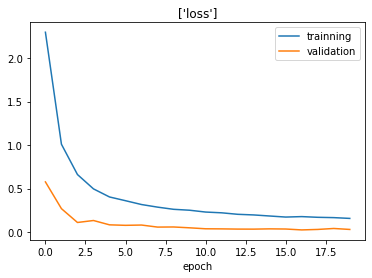

In [52]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['trainning','validation'])
plt.title(['loss'])
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

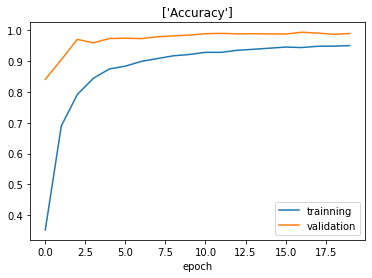

In [53]:
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.legend(['trainning','validation'])
plt.title(['Accuracy'])
plt.xlabel('epoch')

In [54]:
score = model.evaluate(X_test,y_test,verbose=0)
print('Test Score',score[0])
print('Test Accuracy',score[1])

Test Score 0.12113126367330551
Test Accuracy 0.9676167964935303


(32, 32)


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


predicted sign: [34]


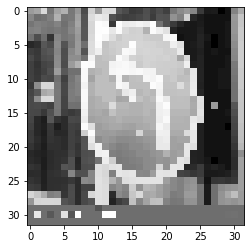

In [55]:
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preproccessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
img = img.reshape(1, 32, 32, 1)

print("predicted sign: "+ str(model.predict_classes(img)))